In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

__Vasicek Model:__ $dr_t = \alpha(b-r_t)dt + \sigma dW_t$   
Точное решение: $r_t \sim N\left(r_0 e^{-\alpha t} + b (1-e^{-\alpha t}),\,\tfrac{\sigma^2}{2\alpha}\left(1-e^{-2\alpha t}\right)\right)
$

In [2]:
def minimizeNLogLikelihood(r):
    dt = 1 
    rt = r    
    N = r.shape[0]
    params0 = np.array([0.0000001,0.5, 0.0000001])
    
    def VasicekLogLikelihood(params):
        alpha, b, sigma = params[0], params[1], params[2] 
        return -(N-1)*np.log(alpha/(sigma**2*(1-np.exp(-2*alpha*dt)))) \
            - alpha/(sigma**2*(1-np.exp(-2*alpha*dt)))*np.sum(-(rt[:-1] - rt[1:]*np.exp(-alpha*dt)-b*(1-np.exp(-alpha*dt)))**2) 
    
    params_opt = minimize(VasicekLogLikelihood, params0, method='Powell')
    return params_opt.x

In [3]:
def MSE(r):

    dt = 1 
    N = r.shape[0]
    params0 = np.array([0.0000001,0.0000001,0.0000001])
    
    def VasicekLogLikelihood(params):
        alpha, b, sigma = params[0], params[1], params[2] 
        return np.mean((r[1:] - r[:-1] - (alpha*(b -r[:-1]) + sigma*np.random.randn()))**2)
    
    params_opt = minimize(VasicekLogLikelihood, params0, method='Powell')
    return params_opt.x

In [4]:
def ClosestTradeDate(day, days_for_predict, dates):
    return dates[dates < day][-days_for_predict]
    

In [5]:
def estimate_params(components, n_components):
    params = np.zeros((n_components,3))

    for i in range(n_components):
        params[i] = minimizeNLogLikelihood(components[:,i])

    return params

In [6]:
def estimate_params_MSE(components, n_components):
    params = np.zeros((n_components,3))

    for i in range(n_components):
        params[i] = MSE(components[:,i])

    return params

In [7]:
def load_bonds(bond_count, forDate):
 
    bond_info = {}

    for i in range( bond_count):
        bond_i = i

        coupons =pd.read_excel('New data/офз_график_выплат.xlsx', bond_i)[['Date', 'Coupon']].astype({'Date':'M8[D]'})

        coupons_date = coupons['Date'].values


    
        info = pd.read_excel('New data/офз_описание.xlsx',bond_i, index_col=0)
        num_coupons = info.loc['Периодичность выплаты купона в год'].values[0]
        
        coupons_rate = coupons['Coupon'].values/num_coupons/100
        coupons_rate = coupons_rate[coupons_date > forDate]

        coupons_date = coupons_date[coupons_date > forDate].reshape(-1,1)
        expDate = np.datetime64(info.loc['Дата погашения'].values[0])

        face = info.loc['Номинальная стоимость'].values[0]

        bond_info[i] = {
            'coupons_date': coupons_date,
            'coupons_rate': coupons_rate,
            'expDate': expDate,
            'face': face
        }
    return bond_info


In [8]:
# def VasicekPath(params,r0, N):
#     dt = 1    
#     alpha, b, sigma = params[0], params[1], params[2]
#     r = [] # варианты аля-ставки на один из аля-TtM  
#     for j in range(N):
#         r1 = r0 + alpha*(b-r0)*dt + sigma*np.sqrt(dt)*np.random.randn()
#         r.append(r1)
#     return r

def VasicekPath(params,r0, N, days_for_predict):
    dt = 1    
    alpha, b, sigma = params[0], params[1], params[2]
    simulations = np.zeros((N,days_for_predict)) # варианты аля-ставки на один из аля-TtM  
    
    
    for j in range(N):
        r = [r0]
        for d in range(days_for_predict):
            R = alpha*(b-r[-1])*dt + sigma*np.sqrt(dt)*np.random.randn()
            r.append(r[-1] + R)
        simulations[j] = r[1:]
    return simulations

In [9]:
from scipy.interpolate import interp1d


def interpolate(bond_count, pca, r0, bond_info, N, days_for_predict):
    inverse_r0 = np.array([r0.values for i in range(N)])
    
    x_axis = [0]+list(r0.index*252)
    xnew = np.arange(0, 30*252, 1)
    
    for bond_i in range(bond_count):
    #переводим аля-ставки в разности реальных ставок 
        inverse_r = pca.inverse_transform(bond_info[bond_i]['simulations'])
        ytm = np.cumsum(np.concatenate((inverse_r0[None, :, :], inverse_r)), 0)

        inverse_r_interpolate = np.zeros((days_for_predict+1, N, len(xnew)))

        for i, data in enumerate(ytm):
            for k, ofz in enumerate(data):
                y = [0]+list(ofz)

                f = interp1d(x_axis, y)
                ynew = f(xnew)

                inverse_r_interpolate[i, k] = ynew
                
        bond_info[bond_i]['inverse_r_interpolate'] = inverse_r_interpolate
    return bond_info

In [10]:
def PriceBond(bond_params, tradeDate, days_for_predict,  N=10):
    coupons_date = bond_params['coupons_date']
    couponRate = bond_params['coupons_rate']
    FaseValue = bond_params['face']/10
    inverse_r_interpolate = bond_params['inverse_r_interpolate']

    TimeToMaturity = np.apply_along_axis(lambda x: int((x - tradeDate)/np.timedelta64(1,'D')), 1, coupons_date)
    B = np.zeros((N, days_for_predict+1))

    for i in range(N): 
        
        #для каждого купона считаем его динамику цены (делим значение купона на показатель дисконтирования)
        for j, k in enumerate(TimeToMaturity):        
            V = FaseValue*couponRate[j] if j != len(TimeToMaturity)-1 else FaseValue*(1+couponRate[j])  

            X = []
            
            for d in range(days_for_predict+1):
                X.append(V/(1+inverse_r_interpolate[d][i][k-d])**(k-d))

            B[i] += X
        
    return B

In [11]:
def estimate_r(bond_count, params, r0_diff, days_for_predict=1,  N=100):
    for bond_i in range(bond_count):
        r = []    
        for j in range(params.shape[0]):        
            r.append(VasicekPath(params[j], r0_diff[j], N, days_for_predict))

        bond_info[bond_i]['simulations'] = np.array(r).T
    return bond_info

In [12]:
def estimate_price(bond_count, bond_info, N, tradeDate):

    for i in range(bond_count):

        p = PriceBond(bond_info[i], tradeDate,  days_for_predict, N=N)

        bond_info[i]['price_path'] = p
        
        
    return bond_info

### смотрим на весь портфель из облигаций на 1 день

In [13]:
def load_real_price(bond_count, price_data, tradeDate, forecastDate):
    price_path = []

    for i in range(bond_count):
#         bond_price = pd.read_excel('New data/офз_данные.xlsx', i, index_col=2).iloc[:, 6:7]
#         bond_price.columns=['price']
        bond_price = price_data[i]

        price_path.append(bond_price.loc[tradeDate:forecastDate+1]['price'])
        

#         bond_result = bond_info[i]
#         dates_index = pd.date_range(tradeDate1, bond_result['expDate'])[:-1]
#         p_path = pd.DataFrame(bond_result['price_path'], columns=dates_index)
        


    return np.array(price_path)

In [14]:
def pricePortfolioInitial(p_real, bond_value = 1):
    w = bond_value/p_real
    return np.sum(w*p_real), w

def pricePortfolio(price, w):
    if len(price.shape) == 2:
        return np.sum(w[:, None]*price, 0)
    else: 
        return np.sum(w*price)

In [15]:
def rebalance(amount0, p_path):
    w = amount0 / sum(amount0)
    value = []
    count = amount0 / p_path[:, 0]
    value.append(sum(amount0))
    
    for i in range(1, p_path.shape[1]):
        p = p_path[:, i]
        port_value = sum(p * count)
        count = (port_value * w) / p
        value.append(port_value)

    return sum(count * p), np.array(value)


def estimate_VaR(amount0, p_pathes, N, alpha=0.99):
    p0_real = p_pathes[:, 0, 0]
    
    port_value_0 = sum(amount0)
    
    port_value_last = np.zeros(N)
    history_value = []
    
    for i in range(N):
        p_path = np.array([x[i] for x in p_pathes])
        port_value_last[i], v  = rebalance(amount0, p_path)
        history_value.append(v)
        
    distr = (port_value_0 - port_value_last) / port_value_0

    return np.percentile(distr, alpha*100), port_value_last, np.array(history_value)
    
def real_loss(market_path, amount0):
    balance, history = rebalance(amount0, market_path)
#     count = amount0 / p0
    return((sum(amount0) - balance) / sum(amount0)), history
    

In [16]:
def make_true_price_path(bond_count, bond_info, p0_real, N, days_for_predict):
    
    
    for i in range(bond_count):
        yields = bond_info[i]['price_path'][:, 1:] / bond_info[i]['price_path'][:, :-1]
        yields = yields[:, :days_for_predict]

        bond_info[i]['price_path'] = np.cumprod(np.concatenate((p0_real[i] + np.zeros((N,1)), 
                   yields), 1), 1)
        
        
    return  bond_info    

In [17]:
ir = pd.read_excel('офз.xlsx', index_col=0, header=1) / 100/252

dates = np.array(['-'.join(x.split('.')[::-1]) for x in ir.index]).astype('M8[D]')
ir.index = dates
ir.sort_index(inplace=True)
dates = dates[::-1][1:]

ir_diff = ir.diff().dropna()# берем разности

n_components = 3
pca = PCA(n_components=n_components)
components = pca.fit_transform(ir_diff)



In [18]:
result = []
startDate0 = np.datetime64('2015-01-01')
finishDate = np.datetime64('2018-12-31')
startDate18 = np.datetime64('2018-01-10')

days_for_predict = 1
bond_count = 5
N = 100
z = 0

bond_price = {}
for i in range(bond_count):
    data = pd.read_excel('New data/офз_данные.xlsx', i, index_col=2).iloc[:, 5:6]
    data.columns=['price']
    bond_price[i] = data
    
#result = pd.DataFrame(columns=['forDate', 'VaR', 'loss'])

for forecastDate in dates[(dates >= startDate18) & (dates <= finishDate)][:]:
    
    startDate = startDate0# + (forecastDate - startDate18)
    
    tradeDate =  ClosestTradeDate(forecastDate, days_for_predict, dates)
    
    print('last traid date before forecase', tradeDate)
    print('forecast date', forecastDate)
    bond_info = load_bonds(bond_count, tradeDate)
    
#     pca = PCA(n_components=n_components)
#     components_for = pca.fit_transform(ir_diff.loc[startDate : tradeDate])
    components_for = components[(dates <= tradeDate) & (dates >= startDate)]
    params = estimate_params(components_for, n_components)
    
    #print(params)
    r0_diff = components_for[-1]
    r0 = ir.loc[ClosestTradeDate(forecastDate, days_for_predict, dates)]
    
    bond_info = estimate_r(bond_count, params,  r0_diff, days_for_predict=days_for_predict, N=N)
    bond_info = interpolate(bond_count, pca, r0, bond_info, N, days_for_predict)
    bond_info = estimate_price(bond_count, bond_info, N, tradeDate)
    
    price_market = load_real_price(bond_count, bond_price, tradeDate, forecastDate)

    bond_info = make_true_price_path(bond_count, bond_info, price_market[:, 0], N, days_for_predict)
    
    porfolio_path = np.array([bond_info[i]['price_path'] for i in range(bond_count)])

    amount0 = np.array([10e6]*bond_count)
    
    VaR, last_value, portfolio_value = estimate_VaR(amount0, porfolio_path, N)
    
    loss, history = real_loss(price_market, amount0 )
    
    print('VaR', VaR, 'loss', loss)
    
    #result.append([forecastDate, VaR, loss])
    
    if loss > VaR:
        z += 1
    print(z)

last traid date before forecase 2018-01-09
forecast date 2018-01-10
VaR 0.0022971848721530424 loss -0.001679009878152609
0
last traid date before forecase 2018-01-10
forecast date 2018-01-11
VaR 0.006387954089851222 loss 0.0014663203996711969
0
last traid date before forecase 2018-01-11
forecast date 2018-01-12
VaR 0.005902209608375438 loss 0.00019920159986242653
0
last traid date before forecase 2018-01-12
forecast date 2018-01-15
VaR 0.002531075828119052 loss -0.000906821613574028
0
last traid date before forecase 2018-01-15
forecast date 2018-01-16
VaR 0.004599552330634063 loss 0.0007676657319384813
0
last traid date before forecase 2018-01-16
forecast date 2018-01-17
VaR 0.005288238870314267 loss 0.0014013992552013696
0
last traid date before forecase 2018-01-17
forecast date 2018-01-18
VaR 0.005138772493361204 loss -0.0007639634352399409
0
last traid date before forecase 2018-01-18
forecast date 2018-01-19
VaR 0.0037496433724202413 loss -0.0013833107085882126
0
last traid date bef

VaR 0.0017702510235247785 loss -0.0012794764514294267
2
last traid date before forecase 2018-04-18
forecast date 2018-04-19
VaR 0.0026661499402264133 loss -0.0034911186302939057
2
last traid date before forecase 2018-04-19
forecast date 2018-04-20
VaR 0.002787410381590981 loss -0.0013934613932989539
2
last traid date before forecase 2018-04-20
forecast date 2018-04-23
VaR 0.003932092608495401 loss -0.0008968161128474772
2
last traid date before forecase 2018-04-23
forecast date 2018-04-24
VaR 0.004404421417871607 loss -0.0014144513370907307
2
last traid date before forecase 2018-04-24
forecast date 2018-04-25
VaR 0.0029316972148235223 loss -0.00010669531813055277
2
last traid date before forecase 2018-04-25
forecast date 2018-04-26
VaR 0.005822463012451502 loss -0.00014325518183425068
2
last traid date before forecase 2018-04-26
forecast date 2018-04-27
VaR 0.005620957029319263 loss -0.0017510731307742
2
last traid date before forecase 2018-04-27
forecast date 2018-04-28
VaR 0.00146762

VaR 0.004025516842572119 loss 0.0013613859873047472
3
last traid date before forecase 2018-07-25
forecast date 2018-07-26
VaR 0.004696842066976929 loss -0.0006191620007662476
3
last traid date before forecase 2018-07-26
forecast date 2018-07-27
VaR 0.003120370068706473 loss 0.0006734398400889337
3
last traid date before forecase 2018-07-27
forecast date 2018-07-30
VaR 0.004938590722987967 loss 0.00012155870078384876
3
last traid date before forecase 2018-07-30
forecast date 2018-07-31
VaR 0.0027109520414521915 loss -0.001075782632511556
3
last traid date before forecase 2018-07-31
forecast date 2018-08-01
VaR 0.0032817633213565295 loss 0.0018282986754989624
3
last traid date before forecase 2018-08-01
forecast date 2018-08-02
VaR 0.00611300875095117 loss 0.0025882203302697838
3
last traid date before forecase 2018-08-02
forecast date 2018-08-03
VaR 0.007951746601084168 loss 0.0005125073325678706
3
last traid date before forecase 2018-08-03
forecast date 2018-08-06
VaR 0.004816385418361

VaR 0.005527868418852378 loss -0.00011839910654589533
10
last traid date before forecase 2018-10-26
forecast date 2018-10-29
VaR 0.005029767715474298 loss -0.00021824223017528652
10
last traid date before forecase 2018-10-29
forecast date 2018-10-30
VaR 0.0024672067385067857 loss -7.934511064276099e-05
10
last traid date before forecase 2018-10-30
forecast date 2018-10-31
VaR 0.004018661888491293 loss 0.000654058305375427
10
last traid date before forecase 2018-10-31
forecast date 2018-11-01
VaR 0.0032553120970413895 loss -0.00038597707976996897
10
last traid date before forecase 2018-11-01
forecast date 2018-11-02
VaR 0.0032940602662252594 loss -0.0007646175611770153
10
last traid date before forecase 2018-11-02
forecast date 2018-11-06
VaR 0.0029653277980631306 loss 0.0010096342191189527
10
last traid date before forecase 2018-11-06
forecast date 2018-11-07
VaR 0.0037539194743945706 loss 0.002999672143495232
10
last traid date before forecase 2018-11-07
forecast date 2018-11-08
VaR 0

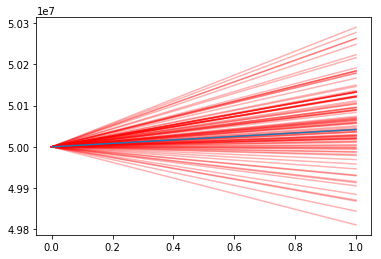

In [19]:
for i in range(100):
    plt.plot( portfolio_value[i], c='r', alpha=0.3)

plt.plot(history)

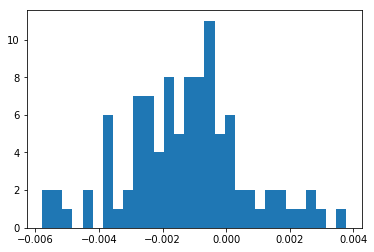

In [20]:
plt.hist((amount0.sum() - last_value)/amount0.sum(), bins=30);

In [21]:
VaR, loss

(0.0031209947666195788, -0.0008377617309658229)

In [22]:
z/len(dates[dates >= np.datetime64('2018-01-06')][:])

0.04435483870967742